In [26]:
import os
import pandas as pd
import numpy as np
import time
import re

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%load_ext autoreload
%autoreload 2

import logging
import sys

import Preprocess_Data
import Train_Models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Define global variables
# get current directory
path = os.getcwd()
# parent directory
parent = os.path.dirname(path)

data_dir = os.path.join(parent,'data/')


### Preprocessing and feature engineering (outside of cv pipeline):
- featur engineering
- splitting
- feature selection

In [37]:
df = pd.read_csv(os.path.join(parent,'data/merged_data.csv'))

In [4]:
preprocessing_test = Preprocess_Data.Preprocessing()
X_train, X_test, y_train, y_test = preprocessing_test.preprocess(df)

Data preprocessing done


### Model training:
- traditional ML models: Linear Regression, Lasso Regression, Random Forest, XGBoost
- Ensemble method using tranditional ML models and equal weights given to each model
- [TO DO] LSTM
- [TO DO] CNN
- [TO DO] combining multiple models
- [TO DO] combining ML approach with numerical models like APSIM


Debugging:
- [TO DO] debug emsemble model error
- [TO DO] edit feature importance class to be independent of model training class

In [7]:
# import data:
X_train = pd.read_csv(os.path.join(data_dir, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

X_test = pd.read_csv(os.path.join(data_dir, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))

In [155]:
def train_model(algo, preprocessing, params, X_train, y_train, X_test, y_test, exp_num, cv_method = 'GridSearchCV', n_trials = 10):

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    model = Train_Models.MLYieldPredictor(algo, preprocessing, params, exp_num = exp_num)
    model.train(X_train, y_train, cv_method = cv_method, n_trials = n_trials)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = model.evaluate(y_train, y_train_pred)
    test_mse = model.evaluate(y_test, y_test_pred)

    print("train MSE: ", train_mse, "test MSE: ", test_mse)

    return model, y_train_pred, y_test_pred
    

In [156]:
# model training test code
preprocessing = Preprocess_Data.make_encoder(X_train)
LR_params= {'model__fit_intercept' : [True, False]}

LR, LR_train_pred, LR_test_pred = train_model(LinearRegression, preprocessing, LR_params, X_train, y_train, X_test, y_test, 0, 'Bayesian', n_trials = 2)

[I 2024-09-13 11:08:44,911] A new study created in memory with name: no-name-0fa39ee8-1e17-4c95-8443-e8e71405e5ce
[W 2024-09-13 11:08:44,913] Trial 0 failed with parameters: {} because of the following error: TypeError("'dict' object is not callable").
Traceback (most recent call last):
  File "/Users/selinawang/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/Users/selinawang/Desktop/Corn Yield Prediction Project/code/Train_Models.py", line 111, in <lambda>
    study.optimize(lambda trial: objective(trial,
                                ^^^^^^^^^^^^^^^^^
  File "/Users/selinawang/Desktop/Corn Yield Prediction Project/code/Train_Models.py", line 66, in objective
    model = instantiate_model(trial, algo, preprocessing_pipeline, make_params)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/selinawang/Desktop/Corn Yield Pred

TypeError: 'dict' object is not callable

In [20]:
preprocessing = Preprocess_Data.make_encoder(X_train)
LR_params= {'model__fit_intercept' : [True, False]}

LR, LR_train_pred, LR_test_pred = train_model(LinearRegression, preprocessing, LR_params, X_train, y_train, X_test, y_test, 0)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best model parameters: {'model__fit_intercept': True}
validation score: -373.350320251864
train MSE:  157.1537016340364 test MSE:  274.2309825141684


In [64]:
# train random forest model
preprocessing = Preprocess_Data.make_encoder(X_train)
RF_params = {'model__n_estimators': [10, 50, 100],'model__max_depth': [5, 10]}

RF, RF_train_pred, RF_test_pred = train_model(RandomForestRegressor, preprocessing, RF_params, X_train, y_train, X_test, y_test, 1)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'model__max_depth': 10, 'model__n_estimators': 50}
validation score: -619.4479461617559
train MSE:  35.512401724725244 test MSE:  477.0751708038402


In [22]:
# xgboost
preprocessing = Preprocess_Data.make_encoder(X_train)

XGB_params = {
        'model__min_child_weight': [1, 5, 10],
        'model__gamma': [0.5, 1, 1.5, 2, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__max_depth': [3, 4, 5]
        }

XGB, XGB_train_pred, XGB_test_pred = train_model(XGBRegressor, preprocessing, XGB_params, X_train, y_train, X_test, y_test, 2)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
best model parameters: {'model__colsample_bytree': 1.0, 'model__gamma': 0.5, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__subsample': 0.6}
validation score: -484.51612094682116
train MSE:  61.508079706230845 test MSE:  372.97324963850747


In [23]:
# Lasso
preprocessing = Preprocess_Data.make_encoder(X_train)

Lasso_params = {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

Lasso, Lasso_train_pred, Lasso_test_pred = train_model(Lasso, preprocessing, Lasso_params, X_train, y_train, X_test, y_test, 3)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
best model parameters: {'model__alpha': 0.1}
validation score: -346.3518205772583
train MSE:  177.90181973989434 test MSE:  288.0736456540596


In [ ]:
# visualize prediction results test code:
viz_test = Train_Models.VisualizePredictions(X_test, y_test, LR_test_pred)

### Emsemble method using trained models:

In [39]:
# basic ensemble model

# read in trained models and save to list
models = []
for i in range(4):
    models.append(pickle.load(open(os.path.join(parent, f'experiments/experiment_{i}/model.save'), 'rb')))
model_names = ['LR', 'RF', 'XGB', 'Lasso']

In [40]:
estimators = list(map(lambda x,y : (x,y), model_names, models))

In [41]:
basic_emsemble = VotingRegressor(estimators)

In [42]:
basic_emsemble.fit(X_train, y_train)

/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: A given column is not a column of the dataframe

In [65]:
# want my model training pipeline to encompass different types of models, including emsemble models and lstm

y_pred = basic_emsemble.predict(X_test)

In [68]:
# evaluate train error:
mean_squared_error(y_train, basic_emsemble.predict(X_train))

76.46291888109843

In [67]:
# evaluate test error:
mean_squared_error(y_test, y_pred)

297.18292098185475

### Visualize Feature Importance:

In [52]:
# print feature importance
import shap

In [97]:
class FeatureImportance():
    def __init__(self, algo, X_test, y_test):
        self.algo = algo
        self.model = self.algo.best_model.named_steps['model']
        self.X_test = X_test
        self.y_test = y_test
    
    def shap_values(self):
        X_test_trans = self.algo.preprocessing_pipeline.fit_transform(X_test)
        transformed_ft_names = self.algo.preprocessing_pipeline.get_feature_names_out()
        X_test_trans = pd.DataFrame(X_test_trans, columns = transformed_ft_names)
        
        explainer = shap.Explainer(self.model, X_test_trans)
        shap_values = explainer(X_test_trans)

        # plot bar plot for global feature importance
        shap.plots.bar(shap_values)


In [98]:
RFimportance = FeatureImportance(RF, X_test, y_test)

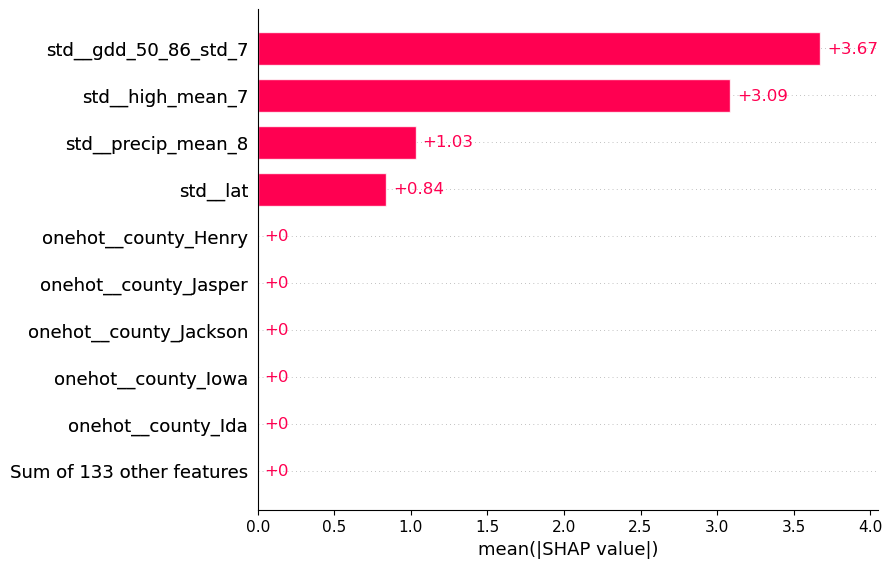

In [99]:
RFimportance.shap_values()

### Optuna experimental code:

In [148]:
# quick example:

import optuna
import os
import pandas as pd
import numpy as np
import time
import re

from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import VotingRegressor

import Train_Models

In [160]:
# define parameters to optimize
def make_params(trial, algo):
    algo_list = ['RandomForestRegressor']
    if algo == RandomForestRegressor:
        params = {'n_estimators': trial.suggest_int('n_estimators',10, 100), 
                    'max_depth': trial.suggest_int('max_depth', 5, 10)}
    else:
        print(f'Choose a different algorithm from {algo_list}')
    return params

In [150]:
# test integration of Optuna to pipeline:
preprocessing = Preprocess_Data.make_encoder(X_train)

RF, RF_train_pred, RF_test_pred = train_model(RandomForestRegressor, preprocessing, RF_params, X_train, y_train, X_test, y_test, 1)


In [157]:
RF.train(X_train, y_train, cv_method = 'Bayesian', n_trials = 1)

[I 2024-09-13 11:10:34,372] A new study created in memory with name: no-name-7e1ecf22-360b-4584-95fc-7cdceb23fd1b
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


is random forest object


/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2024-09-13 11:10:36,898] Trial 0 finished with value: 602.7026338198693 and parameters: {'n_estimators': 20, 'max_depth': 5}. Best is trial 0 with valu

best model parameters: {'n_estimators': 20, 'max_depth': 5}
validation score: 602.7026338198693
is random forest object


In [152]:
y_pred = RF.predict(X_test)

In [153]:
RF.evaluate(y_test, y_pred)

421.1439556319769

In [126]:
def instantiate_RF(trial, algo, proprocessing_pipeline):

    # define parameters to tune
    params = make_params(trial, algo)
    
    # instantiate algorithms
    algo = algo(**params)

    # create pipeline
    pipe = Pipeline([('preprocessor', proprocessing_pipeline), 
                         ('model', algo)])
    
    return pipe

In [127]:
def objective(trial, algo, preprocessing_pipeline, X_train, y_train):
    
    # instantiate model
    
    model = instantiate_RF(trial, algo, preprocessing_pipeline)

    # perform cross validation
    tsp = TimeSeriesSplit(n_splits = 5)
    MSE_scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model, X_train, y_train, scoring = MSE_scorer, cv = tsp)
    
    return np.min([np.mean(scores), np.median(scores)])


In [128]:
study = optuna.create_study()
preprocessing = Preprocess_Data.make_encoder(X_train)

study.optimize(lambda trial: objective(trial, RandomForestRegressor, preprocessing, X_train, y_train), n_trials=1)

[I 2024-09-12 17:44:44,104] A new study created in memory with name: no-name-2160cf15-5669-44c1-b2e0-9ef8cdded792
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


is random forest object


/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was exp

In [159]:
LR, LR_train_pred, LR_test_pred = train_model(RandomForestRegressor, preprocessing, make_params, X_train, y_train, X_test, y_test, 0, 'Bayesian', n_trials = 2)

[I 2024-09-13 11:12:52,655] A new study created in memory with name: no-name-40e563fe-6740-45f6-ac9b-fe6ad79c0858


is random forest object


[I 2024-09-13 11:13:00,533] Trial 0 finished with value: 556.0702671699194 and parameters: {'n_estimators': 33, 'max_depth': 10}. Best is trial 0 with value: 556.0702671699194.


is random forest object


[I 2024-09-13 11:13:11,636] Trial 1 finished with value: 552.520213990696 and parameters: {'n_estimators': 51, 'max_depth': 9}. Best is trial 1 with value: 552.520213990696.


best model parameters: {'n_estimators': 51, 'max_depth': 9}
validation score: 552.520213990696
is random forest object
train MSE:  50.730629744719856 test MSE:  410.1616828779655


In [129]:
study.best_params

{'n_estimators': 60, 'max_depth': 10}

In [74]:
best_trial = study.best_trial

In [82]:
best_trial

FrozenTrial(number=7, state=1, values=[529.0546726407692], datetime_start=datetime.datetime(2024, 9, 12, 16, 13, 30, 704435), datetime_complete=datetime.datetime(2024, 9, 12, 16, 13, 39, 396151), params={'n_estimators': 42, 'max_depth': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=100, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=5, step=1)}, trial_id=7, value=None)

In [81]:
best_RF = instantiate_RF(best_trial, RandomForestRegressor, preprocessing)
best_RF.fit(X_train, y_train)

/Users/selinawang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['county']),
                                                 ('std', StandardScaler(),
                                                  ['year', 'gdd_50_86_mean_9',
                                                   'gdd_50_86_std_7',
                                                   'gdd_50_86_min_5',
                                                   'gdd_50_86_max_9',
                                                   'high_mean_7', 'high_mean_8',
                                                   'high_std_2', 'high_std_5',
                                                   'high_std_8', 'high_min_10',
                                                   'high_min_11', 'high_max_11',
                                                   'high_max_4', 'h...7',
                                                   'high_max_8', 'low_mean_8',
                                                   'low_std_2', 'low_min_5',
                                                   'precip_mean_12_prev',
                                                   'precip_mean_5',
                                                   'precip_mean_6',
                                                   'precip_mean_8',
                                                   'precip_std_3',
                                                   'era5land_srad_mean_10',
                                                   'era5land_srad_mean_5',
                                                   'era5land_srad_std_2',
                                                   'era5land_srad_std_3',
                                                   'era5land_srad_std_6',
                                                   'era5land_srad_min_12_prev', ...])])),
                ('model', RandomForestRegressor(max_depth=8, n_estimators=42))])

In [79]:
y_pred = best_RF.predict(X_test)

In [80]:
# test model performance:
# still overfits lmao.. but that is alright
mean_squared_error(y_test, y_pred)

414.5331381912687

## Archive code:

In [ ]:
# convert to trial parameter format:
trial_params = dict((k,f'trial {v}') for k,v in RF_params.items())
